In [5]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.signal
import matplotlib.pyplot as plt

# General Setup

We have a target distribution and we will try to sample from it using Metropolis MCMC with various proposal distributions.

Some useful links were found here:  
http://www.mcmchandbook.net/HandbookChapter1.pdf  
https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/

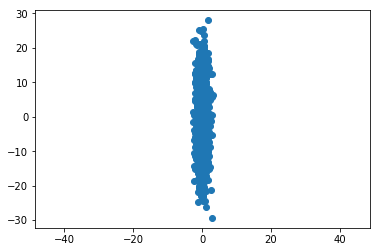

In [6]:
# Target Distribution (Stationary Distribution of the Markov Chain)
# Stretched Normal Distribution in 2D
mean = [0, 0]
cov = [[1, 0], [0, 100]]

target_dist = scipy.stats.multivariate_normal(mean, cov)
data = target_dist.rvs(1000)
df = pd.DataFrame(data, columns=["x", "y"])
plt.plot(df.x, df.y, 'o')
plt.axis('equal')
plt.show()

In [7]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_dist, target_logpdf):
    proposal_dist = proposal_dist(state)
    proposed_state = proposal_dist.rvs(1)
    
    # Note that this is a metropolis algorithm because:
    # scipy.stats.multivariate_normal(state, covar).pdf(proposed_state) == 
    # scipy.stats.multivariate_normal(proposed_state, covar).pdf(state)
    acceptance_prob = min([0, target_dist.logpdf(proposed_state) - target_dist.logpdf(state)])
    
    if np.log(np.random.rand()) < acceptance_prob:
        return proposed_state
    else:
        return state
    
# Acceptance rate at every step
def acceptance_rate_per_step(states):
    states = np.asarray(states)
    steps = 0
    accepted = 0
    acc_rate = []
    for i in range(1,len(states)):
        steps += 1
        if (np.isclose(states[i,0], states[i-1,0], rtol=1e-10, atol=1e-15) and 
            np.isclose(states[i,1], states[i-1,1], rtol=1e-10, atol=1e-15)):
            accepted += 1
        acc_rate.append(accepted/steps)
    return acc_rate

## Normal, $\sigma$ = 0.5

We procede with a proposal distribtuion which is normal and has a covarience of 0.5 times the identity matrix.

In [8]:
# Proposal distribution
def proposal_dist_normal_2d(state, covar=[[0.5, 0], [0, 0.5]]):
    return scipy.stats.multivariate_normal(state, covar)

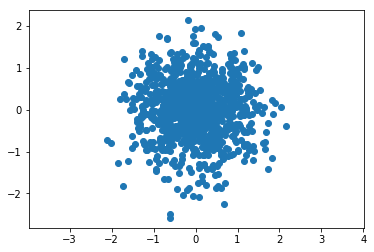

In [9]:
# "Random Walk" Proposal Distribution Centered at previous state
# Normal Distribution in 2D

mean = [0, 0]
cov = [[0.5, 0], [0, 0.5]]

proposal_dist = scipy.stats.multivariate_normal(mean, cov)
data = proposal_dist.rvs(1000)
df = pd.DataFrame(data, columns=["x", "y"])
plt.plot(df.x, df.y, 'o')
plt.axis('equal')
plt.show()

In [12]:
# MCMC Execution
states = [np.array([0,0])]
steps = 10000

for i in range(steps):
    states.append(metropolis_step(states[-1], proposal_dist_normal_2d, target_dist.logpdf))
    
states = np.asarray(states)

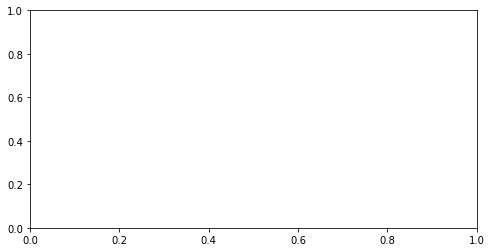

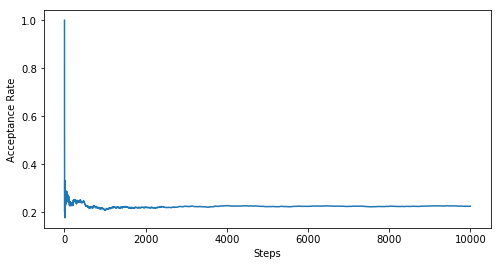

In [13]:
# Acceptance rate plot
acps = acceptance_rate_per_step(states)
plt.figure(figsize=(8, 4))
plt.plot(range(steps ), acps)
plt.xlabel('Steps')
plt.ylabel('Acceptance Rate')
plt.show()

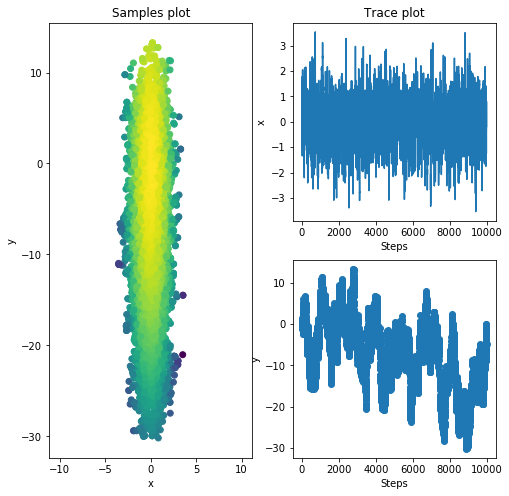

In [14]:
# Sample and trace plots
df = pd.DataFrame(states, columns=["x", "y"])

plt.figure(1, figsize=(8,8))
plt.subplot(121)
plt.scatter(df.x, df.y, c=target_dist.logpdf(states))
plt.axis('equal')
plt.title('Samples plot')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(222)
plt.plot(np.arange(states.shape[0]),df.x)
plt.title('Trace plot')
plt.xlabel('Steps')
plt.ylabel('x')

plt.subplot(224)
plt.scatter(np.arange(states.shape[0]),df.y)
plt.xlabel('Steps')
plt.ylabel('y')

plt.show()

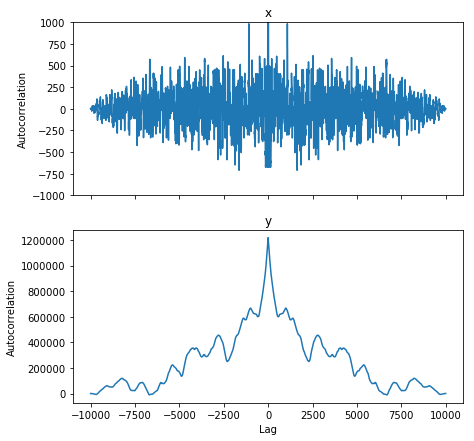

In [15]:
# All lags autocorrelation
autocorx = scipy.signal.correlate(states[:,0], states[:,0])
autocory = scipy.signal.correlate(states[:,1], states[:,1])

fig, (ax_autox, ax_autoy) = plt.subplots(2, 1, sharex=True, figsize=(7,7))

ax_autox.plot(range(-int(autocorx.size/2), int(autocorx.size/2) + 1), autocorx)
ax_autox.set_ylim(-1000,1000)
ax_autox.set_title('x')
ax_autox.set_ylabel('Autocorrelation')

ax_autoy.plot(range(-int(autocory.size/2), int(autocory.size/2) + 1), autocory)
# ax_autoy.set_ylim(-1000,1000)
ax_autoy.set_title('y')
ax_autoy.set_ylabel('Autocorrelation')
ax_autoy.set_xlabel('Lag')
plt.show()

In [16]:
# Autocorrlation as a function of steps
def autocor_lagk_steps_1d(states, lag):
    autocor_lagk = []
    for i in range(len(states)):
        if i <= lag:
            autocor_lagk.append(0)
        else:
            autocor = scipy.signal.correlate(states[:i], states[:i])
            autocor_lagk.append(autocor[int(len(autocor)/2) + lag])
    return np.asarray(autocor_lagk)

lag = 5
acx = autocor_lagk_steps_1d(states[:,0], lag)
acy = autocor_lagk_steps_1d(states[:,1], lag)

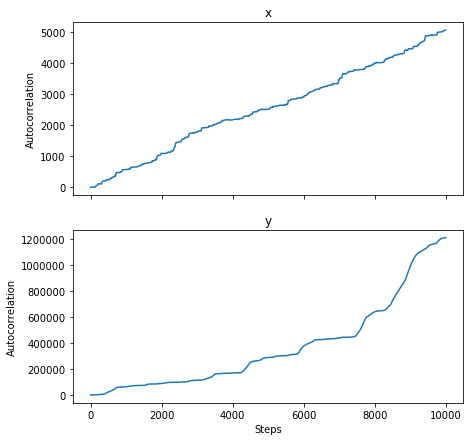

In [17]:
# autocorrelation by steps plot
fig, (ax_autox, ax_autoy) = plt.subplots(2, 1, sharex=True, figsize=(7,7))

ax_autox.plot(range(len(states)), acx)
ax_autox.set_title('x')
ax_autox.set_ylabel('Autocorrelation')

ax_autoy.plot(range(len(states)), acy)
ax_autoy.set_title('y')
ax_autoy.set_ylabel('Autocorrelation')
ax_autoy.set_xlabel('Steps')

plt.show()

## Stretched Normal, $\sigma$ !$\propto$  I

We procede with a proposal distribtuion which is normal, but has covariance which isn't porportional to the identity.